In [1093]:
## Dependencies 

import pandas as pd
import numpy as np
from matplotlib import style
from sklearn.datasets import make_moons, make_blobs
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC 
import cvxpy as cp

style.use('ggplot')

# Kernel - PCA

## K-PCA on benchmark dataset (make moons)

In [951]:

class Kernel_PCA(object):

    def __init__(self, X, Y, mode, gamma, degree, r): 

        self.X = X
        self.y = Y
        self.mode = mode
        self.gamma = gamma
        self.degree = degree
        self.r = r
        self.X_pc = self._kpca_implementation()


    def _kernels(self, x_i, x_j, mode):

        if mode == "rbf":
            return np.exp(-self.gamma * np.linalg.norm(x_i - x_j)**2)

        elif mode == "polynomial":
            return (self.gamma*np.dot(x_i,x_j) + self.r)**self.degree

        elif mode == "sigmoid":
            return np.tanh(self.gamma*np.dot(x_i,x_j) + self.r)


    def _kernel_matrix(self):

        n_samples = self.X.shape[0]
        kernel = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                kernel[i,j] = self._kernels(self.X[i],self.X[j], self.mode)

        return kernel


    def _kpca_implementation(self, PC = 2):

        ## Calculate the Kernel matrix 
        K = self._kernel_matrix()

        ## Centering the symmetric  kernel matrix.
        N = K.shape[0]
        one_n = np.ones((N,N)) / N
        K_ceter = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

        # Caculating eigne values and eigen vectors
        eigvals, eigvecs = eigh(K_ceter)

        # Calculating the new representation of X 
        X_pc = np.column_stack((eigvecs[:,-i] for i in range(1,PC+1)))

        return X_pc
    


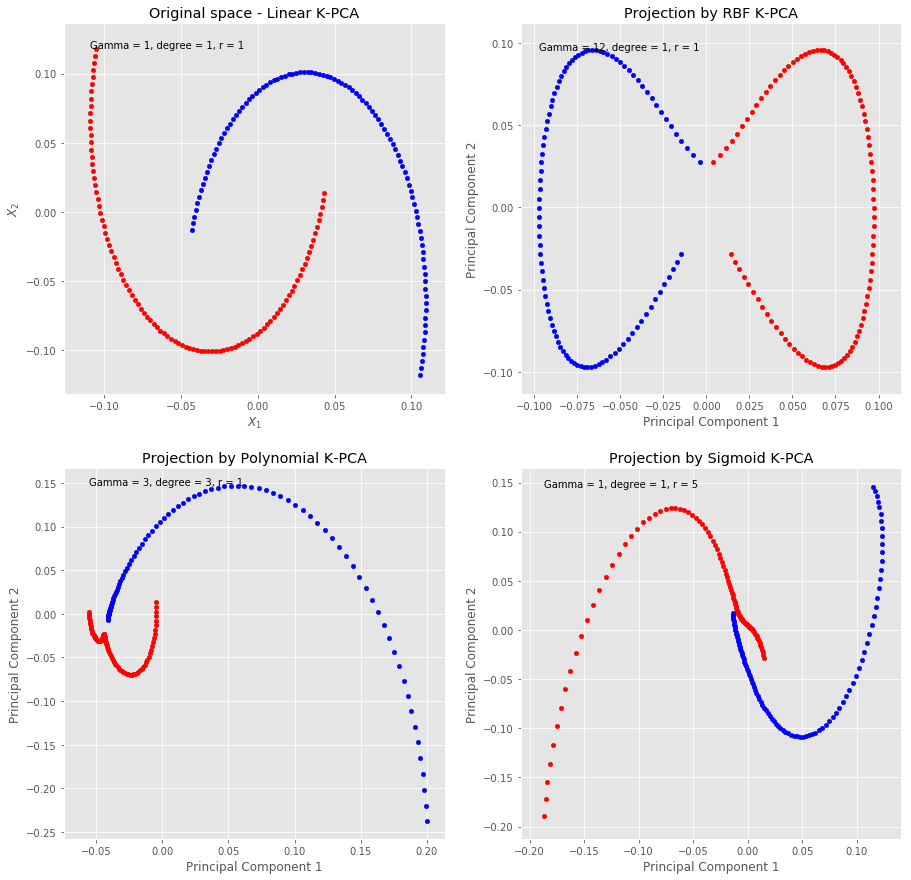

In [953]:
plt.figure(figsize= (15,15))

np.random.seed(0)
#X, Y = make_circles(n_samples=400, factor=.3, noise=.05)
X, Y = make_moons(n_samples=n_samples, random_state=1)
reds = Y == 0
blues = Y == 1

mode_list = [['polynomial',1, 1, 1, 'Original space - Linear K-PCA', '$X_1$','$X_2$'], 
             ['rbf',12, 1, 1, 'Projection by RBF K-PCA', 'Principal Component 1','Principal Component 2'], 
             ['polynomial',3, 3, 1, 'Projection by Polynomial K-PCA', 'Principal Component 1','Principal Component 2'], 
             ['sigmoid',1, 1, 5, 'Projection by Sigmoid K-PCA', 'Principal Component 1','Principal Component 2']]

for n,i in enumerate(mode_list):
    
        mode, gamma, degree, r, title, x_axis, y_axis  = i
        kpca = Kernel_PCA(X, Y, mode, gamma, degree, r)
        X_pc = kpca.X_pc
        
        plt.subplot(2, 2, n+1)
        plt.title(title)
        plt.scatter(X_pc[reds, 0], X_pc[reds, 1], c="red", s=20)
        plt.scatter(X_pc[blues, 0], X_pc[blues, 1], c="blue",s=20)
        plt.xlabel(x_axis)
        plt.ylabel(y_axis)
        plt.text(min(X_pc[:, 0]), max(X_pc[:, 1]),'Gamma = {}, degree = {}, r = {}'.format(gamma, degree, r))

plt.savefig('K_PCA_benchmark.png')
plt.show()

## K-PCA on NUMERAI

In [954]:
## read and display dataframe
df = pd.read_csv('numerai_training_data.csv')
print(df.shape)
df.head()

(108405, 25)


,id,era,data_type,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,target
0,31314,era1,train,0.51999,0.62194,0.55290,0.53790,0.45459,0.48424,0.55901,...,0.45956,0.64501,0.63455,0.41849,0.53119,0.54691,0.58776,0.39615,0.32122,1
1,21294,era1,train,0.49953,0.55550,0.52076,0.52526,0.52533,0.48828,0.38715,...,0.47360,0.49962,0.41754,0.45628,0.52400,0.52315,0.40764,0.49085,0.37679,0
2,59751,era1,train,0.42640,0.61301,0.60097,0.44264,0.44398,0.58975,0.50705,...,0.39000,0.65112,0.55986,0.37617,0.59401,0.61298,0.47080,0.50274,0.35889,0
3,32050,era1,train,0.60113,0.27452,0.70378,0.28974,0.26364,0.33185,0.76004,...,0.38587,0.73085,0.55251,0.39334,0.61907,0.71393,0.67577,0.60380,0.74368,1
4,146447,era1,train,0.47625,0.74148,0.44932,0.65142,0.61908,0.69170,0.32070,...,0.52361,0.47599,0.50155,0.46727,0.47263,0.43662,0.41681,0.37487,0.18306,0


In [955]:
## Preprocessing data frame
# Taking into consideration only rows with 'era' == 'era3'
df = df[df['era'] == 'era3']

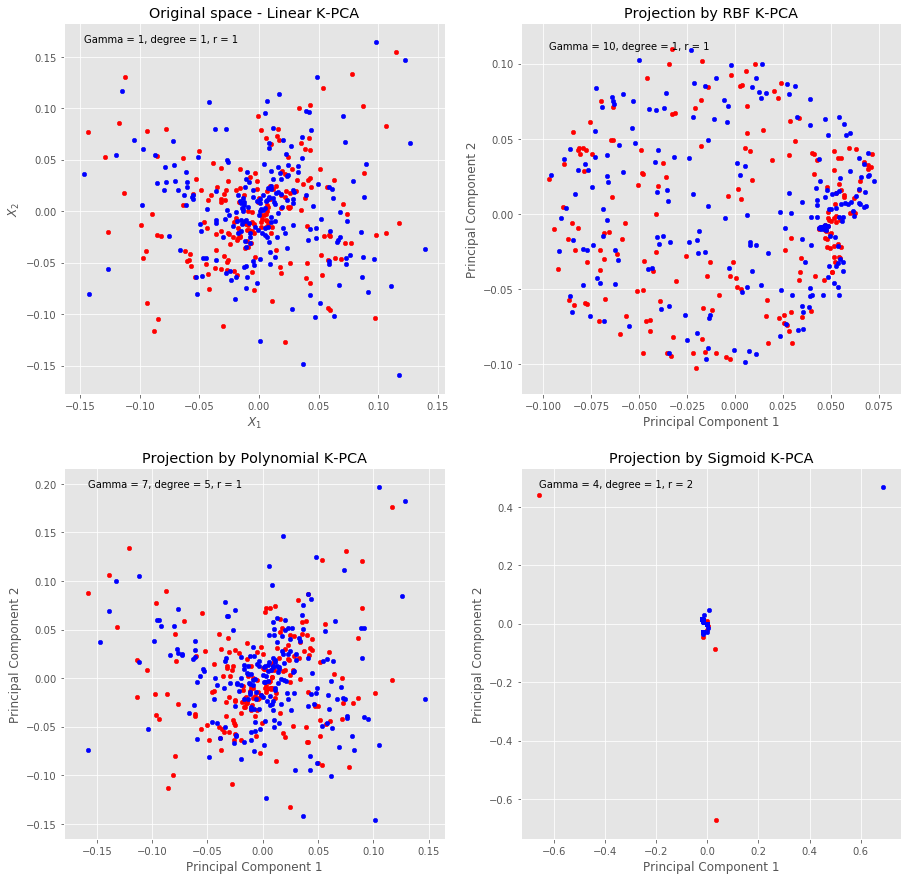

In [966]:
plt.figure(figsize= (15,15))

np.random.seed(0)
#X, Y = make_circles(n_samples=400, factor=.3, noise=.05)
df = df[df['era'] == 'era3']
X = df.values[:,3:-1]
Y = df.values[:,-1]
Y=Y.astype('int')
reds = Y == 0
blues = Y == 1

mode_list = [['polynomial',1, 1, 1, 'Original space - Linear K-PCA', '$X_1$','$X_2$'], 
             ['rbf',10, 1, 1, 'Projection by RBF K-PCA', 'Principal Component 1','Principal Component 2'], 
             ['polynomial',7, 5, 1, 'Projection by Polynomial K-PCA', 'Principal Component 1','Principal Component 2'], 
             ['sigmoid',4, 1, 2, 'Projection by Sigmoid K-PCA', 'Principal Component 1','Principal Component 2']]

for n,i in enumerate(mode_list):
    
        mode, gamma, degree, r, title, x_axis, y_axis  = i
        kpca = Kernel_PCA(X, Y, mode, gamma, degree, r)
        X_pc = kpca.X_pc
        
        plt.subplot(2, 2, n+1)
        plt.title(title)
        plt.scatter(X_pc[reds, 0], X_pc[reds, 1], c="red", s=20)
        plt.scatter(X_pc[blues, 0], X_pc[blues, 1], c="blue",s=20)
        plt.text(min(X_pc[:, 0]), max(X_pc[:, 1]),'Gamma = {}, degree = {}, r = {}'.format(gamma, degree, r))
        plt.xlabel(x_axis)
        plt.ylabel(y_axis)

plt.savefig('K_PCA_Numerai.png')
plt.show()

### LOGISTIC REGRESSION

In [970]:
## Test on Linear Kernel

clf_base = LogisticRegression()
grid  = {'C' : 10.0 ** np.arange(-2,3),
        'penalty' : ['l2','l1']}

cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
clf = GridSearchCV(clf_base, grid, cv = cv)

gamma = 1
degree = 1
r = 1
kpca = Kernel_PCA(X, Y, mode = 'polynomial', gamma = gamma, degree=degree, r=r)
X_pc = kpca.X_pc
clf.fit(X_pc, Y)
print("For gamma = {}, degree = {} and r = {}".format(gamma,degree, r))
print(classification_report(Y, clf.predict(X_pc)))
print(clf.best_estimator_)
print('\n')

For gamma = 1, degree = 1 and r = 1
             precision    recall  f1-score   support

          0       0.57      0.13      0.21       190
          1       0.54      0.92      0.68       213

avg / total       0.55      0.54      0.46       403

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




In [568]:
## Test on RBF kernel

clf_base = LogisticRegression()
grid  = {'C' : 10.0 ** np.arange(-2,3),
        'penalty' : ['l2','l1']}

cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
clf = GridSearchCV(clf_base, grid, cv = cv)
gamma = [0.001, 0.001, 0.3, 0.7,1,3,5,7,9,10,15,20]
for i in gamma:
    kpca = Kernel_PCA(X, Y, mode = 'rbf', gamma = i, degree=1, r=1)
    X_pc = kpca.X_pc
    clf.fit(X_pc, Y)
    print("For gamma value = {}".format(i))
    print(classification_report(Y, clf.predict(X_pc)))
    print(clf.best_estimator_)
    print('\n')

For gamma value = 0.001
             precision    recall  f1-score   support

          0       0.57      0.13      0.21       190
          1       0.54      0.92      0.68       213

avg / total       0.55      0.54      0.46       403

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


For gamma value = 0.001
             precision    recall  f1-score   support

          0       0.57      0.13      0.21       190
          1       0.54      0.92      0.68       213

avg / total       0.55      0.54      0.46       403

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_s

/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 3
             precision    recall  f1-score   support

          0       0.53      0.15      0.24       190
          1       0.54      0.88      0.67       213

avg / total       0.53      0.54      0.46       403

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


For gamma value = 5
             precision    recall  f1-score   support

          0       0.55      0.31      0.40       190
          1       0.56      0.77      0.65       213

avg / total       0.55      0.56      0.53       403

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=Fa

In [569]:
## Test on Polynomial kernel

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

clf_base = LogisticRegression()
grid  = {'C' : 10.0 ** np.arange(-2,3),
        'penalty' : ['l2','l1']}

cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
clf = GridSearchCV(clf_base, grid, cv = cv)
gamma = [0.001, 0.001, 0.3, 0.7,1,3,5,7,9,10,15,20] # 0.7,0.9,1,3,5,7,9,10,15,20
degree = [4,5,6,7,8,9]
r = [1,2,3,4,5]
for i in gamma:
    for j in degree:
        for k in r:
            kpca = Kernel_PCA(X, Y, mode = 'polynomial', gamma = i, degree=j, r=k)
            X_pc = kpca.X_pc
            clf.fit(X_pc, Y)
            print("For gamma value = {} and degree value = {} and bias value = {}".format(i,j,k))
            print(classification_report(Y, clf.predict(X_pc)))
            print(clf.best_estimator_)
            print('\n')

For gamma value = 0.001 and degree value = 4 and bias value = 1
             precision    recall  f1-score   support

          0       0.57      0.13      0.21       190
          1       0.54      0.92      0.68       213

avg / total       0.55      0.54      0.46       403

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


For gamma value = 0.001 and degree value = 4 and bias value = 2
             precision    recall  f1-score   support

          0       0.57      0.13      0.21       190
          1       0.54      0.92      0.68       213

avg / total       0.55      0.54      0.46       403

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2'

In [570]:
## Test on Sigmoid kernel

clf_base = LogisticRegression()
grid  = {'C' : 10.0 ** np.arange(-2,3),
        'penalty' : ['l2','l1']}

cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
clf = GridSearchCV(clf_base, grid, cv = cv)
gamma = [0.001, 0.001, 0.3, 0.7,1,4,7,9,10,15,20] # 0.7,0.9,1,3,5,7,9,10,15,20
r = [1,2,3,4,5,6]
for i in gamma:
    for k in r:
        kpca = Kernel_PCA(X, Y, mode = 'sigmoid', gamma = i, degree=1, r=k)
        X_pc = kpca.X_pc
        clf.fit(X_pc, Y)
        print("For gamma value = {} and bias value = {}".format(i,k))
        print(classification_report(Y, clf.predict(X_pc)))
        print(clf.best_estimator_)
        print('\n')

For gamma value = 0.001 and bias value = 1
             precision    recall  f1-score   support

          0       0.57      0.13      0.21       190
          1       0.54      0.92      0.68       213

avg / total       0.55      0.54      0.46       403

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


For gamma value = 0.001 and bias value = 2
             precision    recall  f1-score   support

          0       0.57      0.13      0.21       190
          1       0.54      0.92      0.68       213

avg / total       0.55      0.54      0.46       403

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', t

/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 4 and bias value = 2
             precision    recall  f1-score   support

          0       1.00      0.01      0.02       190
          1       0.53      1.00      0.69       213

avg / total       0.75      0.53      0.38       403

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


For gamma value = 4 and bias value = 3
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.000

/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 4 and bias value = 4
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 4 and bias value = 5
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 4 and bias value = 6
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 7 and bias value = 1
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 7 and bias value = 2
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 7 and bias value = 3
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 7 and bias value = 4
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 7 and bias value = 5
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 7 and bias value = 6
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 9 and bias value = 1
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 9 and bias value = 2
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 9 and bias value = 3
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 9 and bias value = 4
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 9 and bias value = 5
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 9 and bias value = 6
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 10 and bias value = 1
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 10 and bias value = 2
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 10 and bias value = 3
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 10 and bias value = 4
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 10 and bias value = 5
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 10 and bias value = 6
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 15 and bias value = 1
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 15 and bias value = 2
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 15 and bias value = 3
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 15 and bias value = 4
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 15 and bias value = 5
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 15 and bias value = 6
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 20 and bias value = 1
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 20 and bias value = 2
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 20 and bias value = 3
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 20 and bias value = 4
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 20 and bias value = 5
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 20 and bias value = 6
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### SUPPORT VECTOR MACHINES

In [971]:
## Test on Linear Kernel

Y=Y.astype('int')
clf_base =  SVC()
grid = {'C' : [0.01,0.1,1,10,100], 
        'kernel' : ['linear','rbf','sigmoid'], 
        'gamma' : list(np.random.choice(np.linspace(0,10, 100),4)),
        'degree' : [1,3,5,8],
        'coef0' : [1,2,3,4]}

cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
clf = GridSearchCV(clf_base, grid, cv = cv)

gamma = 1
degree = 1
r = 1
kpca = Kernel_PCA(X, Y, mode = 'polynomial', gamma = gamma, degree=degree, r=r)
X_pc = kpca.X_pc
clf.fit(X_pc, Y)
print("For gamma = {}, degree = {} and r = {}".format(gamma,degree, r))
print(classification_report(Y, clf.predict(X_pc)))
print(clf.best_estimator_)
print('\n')

For gamma = 1, degree = 1 and r = 1
             precision    recall  f1-score   support

          0       0.70      0.08      0.15       190
          1       0.54      0.97      0.69       213

avg / total       0.61      0.55      0.44       403

SVC(C=10, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=9.8989898989899,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




In [563]:
## TESTS oON THE RBF KERNEL

Y=Y.astype('int')
clf_base =  SVC()
grid = {'C' : [0.01,0.1,1,10,100], 
        'kernel' : ['linear','rbf','sigmoid'], 
        'gamma' : list(np.random.choice(np.linspace(0,10, 100),4)),
        'degree' : [1,3,5,8],
        'coef0' : [1,2,3,4]}

cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
clf = GridSearchCV(clf_base, grid, cv = cv)
gamma = list(np.random.choice(np.linspace(0,1, 100),10))
for i in gamma:
    kpca = Kernel_PCA(X, Y, mode = 'rbf', gamma = i, degree=1, r=1)
    X_pc = kpca.X_pc
    clf.fit(X_pc, Y)
    
    print("For gamma value = {}".format(i))
    print(classification_report(Y, clf.predict(X_pc)))
    print(clf.best_estimator_)
    print('\n')

For gamma value = 3.9393939393939394
             precision    recall  f1-score   support

          0       0.56      0.20      0.29       190
          1       0.55      0.86      0.67       213

avg / total       0.55      0.55      0.49       403

SVC(C=100, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=2.525252525252525,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


For gamma value = 7.6767676767676765
             precision    recall  f1-score   support

          0       0.55      0.24      0.34       190
          1       0.55      0.83      0.66       213

avg / total       0.55      0.55      0.51       403

SVC(C=100, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=3.0303030303030303,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


For gamma value = 4.747

/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 2.2222222222222223
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=2.525252525252525,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 0.5050505050505051
             precision    recall  f1-score   support

          0       0.59      0.17      0.26       190
          1       0.55      0.90      0.68       213

avg / total       0.57      0.55      0.48       403

SVC(C=100, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=3.0303030303030303,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


For gamma value = 2.121212121212121
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=2.525252525252525,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 9.797979797979798
             precision    recall  f1-score   support

          0       0.55      0.20      0.29       190
          1       0.54      0.85      0.67       213

avg / total       0.55      0.55      0.49       403

SVC(C=100, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=3.0303030303030303,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




In [573]:
## TESTS ON THE POLYNOMIAL KERNEL

Y=Y.astype('int')
clf_base =  SVC()
grid = {'C' : [0.01,0.1,1,10,100], 
        'kernel' : ['linear','rbf','sigmoid'], 
        'gamma' : list(np.random.choice(np.linspace(0,10, 100),4)),
        'degree' : [1,3,5,8],
        'coef0' : [1,2,3,4]}

cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
clf = GridSearchCV(clf_base, grid, cv = cv)
gamma = list(np.random.choice(np.linspace(0,10, 100),5))
degree = [2,6,9,12]
r = [1,3,5]
for i in gamma:
    for j in degree:
        for k in r:
            kpca = Kernel_PCA(X, Y, mode = 'rbf', gamma = i, degree=j, r=i)
            X_pc = kpca.X_pc
            clf.fit(X_pc, Y)

            print("For gamma value = {} and degree value = {} and bias value = {}".format(i,j,k))
            print(classification_report(Y, clf.predict(X_pc)))
            print(clf.best_estimator_)
            print('\n')

For gamma value = 0.8080808080808081 and degree value = 2 and bias value = 1
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 0.8080808080808081 and degree value = 2 and bias value = 3
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 0.8080808080808081 and degree value = 2 and bias value = 5
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 0.8080808080808081 and degree value = 6 and bias value = 1
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 0.8080808080808081 and degree value = 6 and bias value = 3
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 0.8080808080808081 and degree value = 6 and bias value = 5
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 0.8080808080808081 and degree value = 9 and bias value = 1
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 0.8080808080808081 and degree value = 9 and bias value = 3
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 0.8080808080808081 and degree value = 9 and bias value = 5
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 0.8080808080808081 and degree value = 12 and bias value = 1
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 0.8080808080808081 and degree value = 12 and bias value = 3
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 0.8080808080808081 and degree value = 12 and bias value = 5
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 5.555555555555555 and degree value = 2 and bias value = 1
             precision    recall  f1-score   support

          0       0.59      0.28      0.38       190
          1       0.56      0.82      0.67       213

avg / total       0.57      0.57      0.53       403

SVC(C=100, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=5.151515151515151,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


For gamma value = 5.555555555555555 and degree value = 2 and bias value = 3
             precision    recall  f1-score   support

          0       0.59      0.28      0.38       190
          1       0.56      0.82      0.67       213

avg / total       0.57      0.57      0.53       403

SVC(C=100, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=5.151515151515151,
  kernel='rbf', max_iter=-1, probability=False, random_stat

/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 1.3131313131313131 and degree value = 2 and bias value = 3
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 1.3131313131313131 and degree value = 2 and bias value = 5
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 1.3131313131313131 and degree value = 6 and bias value = 1
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 1.3131313131313131 and degree value = 6 and bias value = 3
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 1.3131313131313131 and degree value = 6 and bias value = 5
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 1.3131313131313131 and degree value = 9 and bias value = 1
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 1.3131313131313131 and degree value = 9 and bias value = 3
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 1.3131313131313131 and degree value = 9 and bias value = 5
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 1.3131313131313131 and degree value = 12 and bias value = 1
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 1.3131313131313131 and degree value = 12 and bias value = 3
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 1.3131313131313131 and degree value = 12 and bias value = 5
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=0.01, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.373737373737374,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 7.171717171717171 and degree value = 2 and bias value = 1
             precision    recall  f1-score   support

          0       0.55      0.21      0.30       190
          1       0.55      0.85      0.66       213

avg / total       0.55      0.55      0.49       403

SVC(C=100, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.474747474747475,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


For gamma value = 7.171717171717171 and degree value = 2 and bias value = 3
             precision    recall  f1-score   support

          0       0.55      0.21      0.30       190
          1       0.55      0.85      0.66       213

avg / total       0.55      0.55      0.49       403

SVC(C=100, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=7.474747474747475,
  kernel='rbf', max_iter=-1, probability=False, random_stat

In [961]:
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

Y=Y.astype('int')
clf_base =  SVC()
grid = {'C' : [0.01,0.1,1,10,100], 
        'kernel' : ['linear','rbf','sigmoid'], 
        'gamma' : list(np.random.choice(np.linspace(0,10, 100),4)),
        'degree' : [1,3,5,8],
        'coef0' : [1,2,3,4]}

cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
clf = GridSearchCV(clf_base, grid, cv = cv)
gamma = [0.001, 0.001, 0.3, 0.7,1,4,7,9,10,15,20] # 0.7,0.9,1,3,5,7,9,10,15,20
r = [1,2,3,4,5,6]
for i in gamma:
    for k in r:
        kpca = Kernel_PCA(X, Y, mode = 'rbf', gamma = i, degree=1, r=i)
        X_pc = kpca.X_pc
        clf.fit(X_pc, Y)

        print("For gamma value = {} and bias value = {}".format(i,k))
        print(classification_report(Y, clf.predict(X_pc)))
        print(clf.best_estimator_)
        print('\n')

For gamma value = 0.001 and bias value = 1
             precision    recall  f1-score   support

          0       0.70      0.08      0.15       190
          1       0.54      0.97      0.69       213

avg / total       0.61      0.55      0.44       403

SVC(C=10, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=9.797979797979798,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


For gamma value = 0.001 and bias value = 2
             precision    recall  f1-score   support

          0       0.70      0.08      0.15       190
          1       0.54      0.97      0.69       213

avg / total       0.61      0.55      0.44       403

SVC(C=10, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=9.797979797979798,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


For gamma valu

/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 10 and bias value = 2
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=10, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=3.131313131313131,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 10 and bias value = 3
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=10, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=3.131313131313131,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 10 and bias value = 4
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=10, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=3.131313131313131,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 10 and bias value = 5
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=10, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=3.131313131313131,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 10 and bias value = 6
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.53      1.00      0.69       213

avg / total       0.28      0.53      0.37       403

SVC(C=10, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=3.131313131313131,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For gamma value = 15 and bias value = 1
             precision    recall  f1-score   support

          0       0.62      0.12      0.20       190
          1       0.54      0.93      0.69       213

avg / total       0.58      0.55      0.46       403

SVC(C=10, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=3.131313131313131,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


For gamma value = 15 and bias value = 2
             precision    recall  f1-score   support

          0       0.62      0.12      0.20       190
          1       0.54      0.93      0.69       213

avg / total       0.58      0.55      0.46       403

SVC(C=10, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma=3.131313131313131,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


For gamma value = 15

# Kernalised Kmeans

## Vanilla K-means

In [960]:
## Vanilla K-means

def assign(distances, rows, n_clusters, centers_temp, threshold = 0):
    
    global stability
    reassign_dict = dict()
    for i in range(n_clusters): reassign_dict[i] = list()

    for r in range(rows):
        temp = [dist_from_ref[i][r] for i in range(n_clusters)]
        reassign_dict[temp.index(min(temp))].append(min(temp))
        
    centers = center_calc(reassign_dict, n_clusters)
    if np.linalg.norm(centers - centers_temp) == threshold : stability = True
    
    return reassign_dict, centers


def center_calc(reassign_dict, n_clusters):
    
    temp_list = list()
    
    for n in range(n_clusters):
        temp_X = X[[j[0] for j in reassign_dict[n]]]
        temp_list.append([temp_X[:,0].mean(), temp_X[:,1].mean()])
    
    return np.array(temp_list)
    
    
def distance(x,x_i, mode = 'linear'):
    
    if mode == 'linear':
        return np.linalg.norm(x - x_i)
    
    elif mode == 'rbf':
        return np.exp(-GAMMA * np.linalg.norm(x - x_i)**2)
        

n_clusters = 4
stability = False 
GAMMA = 1

# selecting 'n_clusters' points at random
idx = random.sample(range(1, X.shape[0]), n_clusters)
centers_temp = X[idx]

chk = 0

while not stability:
    
    dist_from_ref = dict()

    for n in range(n_clusters):

        dist_from_ref[n] = list()
        for i in range(X.shape[0]):
            temp_dist =(i, distance(centers_temp[n],X[i], mode = 'linear'))
            dist_from_ref[n].append(temp_dist)
            
    
    dic, centers_temp = assign(dist_from_ref, X.shape[0], n_clusters, centers_temp)
    
    chk += 1
    if chk == 100: break


## Kernalized Kmeans

In [962]:
"""
- Select dataset
- Select k centroids at random
- Create k clusters by assigning points randomly to the selected clusters
    - Calculate similarity between points and clusters in new space.
    - we get new clusters
    - repeat until stability
"""

class Kernel_KMEANS(object):


    def __init__(self, X, Y, mode, gamma, degree, r, n_clusters): 

        self.X = X
        self.y = Y
        self.mode = mode
        self.gamma = gamma
        self.degree = degree
        self.r = r
        self.n_clusters = n_clusters

        self.stability = False
        self.cluster_dict = dict()
        self.kernel =  np.zeros((X.shape[0], X.shape[0]))

        self._kmeans_implementation()


    def _kernels(self, x_i, x_j):

        if self.mode == "rbf":
            return np.exp(-self.gamma * np.linalg.norm(x_i - x_j)**2)

        elif self.mode == "polynomial":
            return (self.gamma*np.dot(x_i,x_j) + self.r)**self.degree

        elif self.mode == "sigmoid":
            return np.tanh(self.gamma*np.dot(x_i,x_j) + self.r )


    def _kernel_matrix(self):

        n_samples = self.X.shape[0]
        for i in range(n_samples):
            for j in range(n_samples):
                self.kernel[i,j] = self._kernels(self.X[i],self.X[j])


    def _random_cluster_assgin(self):

        n_samples = self.X.shape[0]
        shuffled_idx = list(np.random.permutation(n_samples))
        for cluster in range(self.n_clusters): self.cluster_dict[cluster] = list()
        for i in range(n_samples):
            random_centroid = random.randint(0, self.n_clusters-1)
            self.cluster_dict[random_centroid].append((shuffled_idx[i],self.X[shuffled_idx[i]]))



    def _third_term_obj_function(self,idx_list):

        output = 0
        for j in idx_list:
            for l in idx_list:
                output += self.kernel[j,l]

        # if statement to avoid division by zero
        if idx_list: return output/(len(idx_list)**2)
        else: return output


    def _second_term_obj_function(self, idx_list, i):

        output = 0
        for j in idx_list:
            output += self.kernel[i,j]

        # if statement to avoid division by zero
        if idx_list: return 2*output/len(idx_list)
        else: return output


    def _reassign(self, distance_dict, n_samples):

        temp_cluster_dict = dict()
        for cluster in range(self.n_clusters): temp_cluster_dict[cluster] = list()

        for i in range(n_samples):
            temp_list = [distance_dict[cluster][i] for cluster in range(self.n_clusters)]
            temp_cluster_dict[temp_list.index(min(temp_list))].append((i,self.X[i]))

        self._check(temp_cluster_dict) # checking if stability has been attained
        self.cluster_dict =  temp_cluster_dict



    def _check(self, temp_cluster_dict):

        temp_1 = [self.cluster_dict[0][i][0] for i in range(len(self.cluster_dict[0]))]
        temp_2 = [temp_cluster_dict[0][i][0] for i in range(len(temp_cluster_dict[0]))]

        if temp_1 == temp_2: self.stability = True



    def _kmeans_implementation(self):


        self._random_cluster_assgin() # Randomly assign points to clusters
        self._kernel_matrix()
        n_samples = self.X.shape[0]
        check = 0 # Check on infinite iterations

        while not self.stability:

            ## Caculating similarity/distance between points and clusters in new space

            distance_dict = dict()
            for cluster in range(self.n_clusters):

                distance_dict[cluster] = list()

                # Calculating 3rd term in objective function 
                temp_idx_list = [self.cluster_dict[cluster][i][0] for i in range(len(self.cluster_dict[cluster]))]
                third_term = self._third_term_obj_function(temp_idx_list)

                for i in range(n_samples):

                    # Calculating 2nd term in objective function
                    second_term = self._second_term_obj_function(temp_idx_list, i)

                    # Calculating the distance of instance 'i' from cluster
                    dist_i = self.kernel[i,i] - 2*second_term + third_term
                    distance_dict[cluster].append(dist_i)


            self._reassign(distance_dict, n_samples)   

            check += 1
            if check == 20 : break




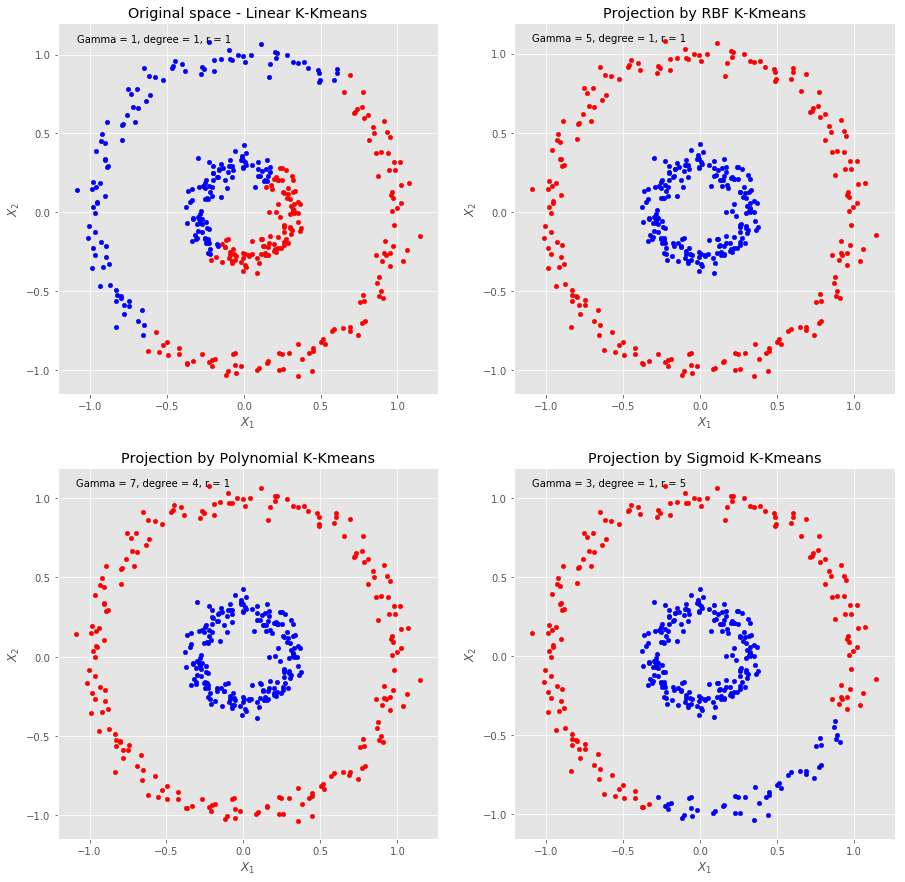

In [972]:
plt.figure(figsize= (15,15))

np.random.seed(0)

n_samples = 400
n_clusters = 2
X, Y = make_circles(n_samples=n_samples, factor=.3, noise=.05, random_state=42)
#X, Y = make_moons(n_samples=n_samples, random_state=1)

mode_list = [['polynomial',1, 1, 1, 'Original space - Linear K-Kmeans', '$X_1$','$X_2$'], 
             ['rbf',5, 1, 1, 'Projection by RBF K-Kmeans', '$X_1$','$X_2$'], 
             ['polynomial',7, 4, 1, 'Projection by Polynomial K-Kmeans', '$X_1$','$X_2$'], 
             ['sigmoid',3, 1, 5, 'Projection by Sigmoid K-Kmeans', '$X_1$','$X_2$']]

for n,i in enumerate(mode_list):
    
        mode, gamma, degree, r, title, x_axis, y_axis  = i
        k_kmeans = Kernel_KMEANS(X, Y, mode, gamma, degree, r, n_clusters)
        cluster_dict = k_kmeans.cluster_dict
        Y_ = np.ones((n_samples,))
        temp_list = [cluster_dict[0][i][0] for i in range(len(cluster_dict[0]))]
        Y_[temp_list] = 0
        
        reds = Y_ == 0
        blues = Y_ == 1
        
        plt.subplot(2, 2, n+1)
        plt.title(title)
        plt.scatter(X[reds, 0], X[reds, 1], c="red", s=20)
        plt.scatter(X[blues, 0], X[blues, 1], c="blue",s=20)
        plt.xlabel(x_axis)
        plt.ylabel(y_axis)
        plt.text(min(X[:, 0]), max(X[:, 1]),'Gamma = {}, degree = {}, r = {}'.format(gamma, degree, r))

plt.savefig('K_Kmeans_benchmark.png')        
plt.show()

In [973]:
## TEST ON RBF KERNEL

from sklearn.metrics import confusion_matrix, classification_report
df = df[df['era'] == 'era3']
X = df.values[:,3:-1]
Y = df.values[:,-1]
Y = Y.astype('int')

gamma = 1
degree = 1
r = 1
k_kmeans = Kernel_KMEANS(X, Y, mode='polynomial', gamma=gamma, degree=degree, r=r, n_clusters=2)
cluster_dict = k_kmeans.cluster_dict
Y_ = np.ones((X.shape[0],))
temp_list = [cluster_dict[0][i][0] for i in range(len(cluster_dict[0]))]
Y_[temp_list] = 0

print("For gamma = {}, degree = {} and r = {}".format(gamma, degree, r))
print(classification_report(Y, Y_))
print('\n')

For gamma = 1, degree = 1 and r = 1
             precision    recall  f1-score   support

          0       0.50      0.60      0.55       190
          1       0.57      0.47      0.51       213

avg / total       0.54      0.53      0.53       403





In [978]:
## TEST ON RBF KERNEL

from sklearn.metrics import confusion_matrix, classification_report
df = df[df['era'] == 'era3']
X = df.values[:,3:-1]
Y = df.values[:,-1]
Y = Y.astype('int')

gamma =list(np.random.choice(np.linspace(0,1, 100),10))
for i in gamma:
    k_kmeans = Kernel_KMEANS(X, Y, mode='rbf', gamma=i, degree=1, r=1, n_clusters=2)
    cluster_dict = k_kmeans.cluster_dict
    Y_ = np.ones((X.shape[0],))
    temp_list = [cluster_dict[0][i][0] for i in range(len(cluster_dict[0]))]
    Y_[temp_list] = 0
    
    print("For gamma value = {}".format(i))
    print(classification_report(Y, Y_))
    print('\n')

For gamma value = 0.5050505050505051
             precision    recall  f1-score   support

          0       0.50      0.56      0.53       190
          1       0.56      0.50      0.53       213

avg / total       0.53      0.53      0.53       403



For gamma value = 0.6666666666666667
             precision    recall  f1-score   support

          0       0.48      0.67      0.56       190
          1       0.55      0.37      0.44       213

avg / total       0.52      0.51      0.50       403



For gamma value = 0.5656565656565657
             precision    recall  f1-score   support

          0       0.45      0.48      0.46       190
          1       0.51      0.48      0.49       213

avg / total       0.48      0.48      0.48       403



For gamma value = 0.8080808080808082
             precision    recall  f1-score   support

          0       0.45      0.50      0.47       190
          1       0.50      0.45      0.48       213

avg / total       0.48      0.47      0.

In [560]:
## TESTS oON THE POLYNOMIAL KERNEL

from sklearn.metrics import confusion_matrix, classification_report
df = df[df['era'] == 'era3']
X = df.values[:,3:-1]
Y = df.values[:,-1]
Y = Y.astype('int')

gamma =list(np.random.choice(np.linspace(0,1, 100),3))
degree = [2,6,10]
r = [1,2,3]

for i in gamma:
    for j in degree:
        for k in r:
            
            k_kmeans = Kernel_KMEANS(X, Y, mode='polynomial', gamma=i, degree=j, r=k, n_clusters=2)
            cluster_dict = k_kmeans.cluster_dict
            Y_ = np.ones((X.shape[0],))
            temp_list = [cluster_dict[0][i][0] for i in range(len(cluster_dict[0]))]
            Y_[temp_list] = 0


            print("For gamma value = {} and degree = {} and r ={}".format(i,j,k))
            print(classification_report(Y, Y_))
            print('\n')

For gamma value = 0.33333333333333337 and degree = 2 and r =1
             precision    recall  f1-score   support

          0       0.50      0.60      0.55       190
          1       0.57      0.47      0.51       213

avg / total       0.54      0.53      0.53       403



For gamma value = 0.33333333333333337 and degree = 2 and r =2
             precision    recall  f1-score   support

          0       0.43      0.40      0.42       190
          1       0.50      0.53      0.51       213

avg / total       0.47      0.47      0.47       403



For gamma value = 0.33333333333333337 and degree = 2 and r =3
             precision    recall  f1-score   support

          0       0.50      0.60      0.55       190
          1       0.57      0.47      0.51       213

avg / total       0.54      0.53      0.53       403



For gamma value = 0.33333333333333337 and degree = 6 and r =1
             precision    recall  f1-score   support

          0       0.43      0.40      0.42     

In [562]:
## TESTS oON THE SIGMOID KERNEL

from sklearn.metrics import confusion_matrix, classification_report
df = df[df['era'] == 'era3']
X = df.values[:,3:-1]
Y = df.values[:,-1]
Y = Y.astype('int')

gamma =list(np.random.choice(np.linspace(0,1, 100),6))
r = [1,2,3,4,5,6]

for i in gamma:
    for k in r:

        k_kmeans = Kernel_KMEANS(X, Y, mode='sigmoid', gamma=i, degree=1, r=k, n_clusters=2)
        cluster_dict = k_kmeans.cluster_dict
        Y_ = np.ones((X.shape[0],))
        temp_list = [cluster_dict[0][i][0] for i in range(len(cluster_dict[0]))]
        Y_[temp_list] = 0


        print("For gamma value = {} and degree = {} and r ={}".format(i,j,k))
        print(classification_report(Y, Y_))
        print('\n')

For gamma value = 0.4141414141414142 and degree = 10 and r =1
             precision    recall  f1-score   support

          0       0.43      0.39      0.41       190
          1       0.50      0.54      0.52       213

avg / total       0.47      0.47      0.47       403



For gamma value = 0.4141414141414142 and degree = 10 and r =2
             precision    recall  f1-score   support

          0       0.50      0.61      0.55       190
          1       0.57      0.46      0.51       213

avg / total       0.54      0.53      0.53       403



For gamma value = 0.4141414141414142 and degree = 10 and r =3
             precision    recall  f1-score   support

          0       0.43      0.39      0.41       190
          1       0.50      0.54      0.52       213

avg / total       0.47      0.47      0.47       403



For gamma value = 0.4141414141414142 and degree = 10 and r =4
             precision    recall  f1-score   support

          0       0.43      0.39      0.41     

# Kernalized One Class SVM

In [6]:
"""
- Given samples from the +ve class only
- The task is to detect outliers
- Useful in the following applications:
    - taking an image, if there's like a fingerprint or shit
    we can simply use one class learning (model trained on
    good images and classifier would know how a good photo
    looks like) to remove anomalies
- In SVDD, one should find the minimum circumsribing hyper-
ball in high dimensional space.
- The outliers are associated with outliers

Steps:
------
- Get/generate data set
- Define kernel matrix (gram matrix)
- Initialize weights (alpha, gamma, beta)
- Calculate the two parts of the loss function
- Calculate the loss
- Calculate new weights
- Update weights w.r.t weights
- Define the upadate 
"""

In [1082]:
class SVDD(object):


    def __init__(self, X, Y, mode, gamma, degree, r, C):

        self.X = X
        self.Y = Y
        self.mode = mode
        self.gamma = gamma
        self.degree = degree
        self.r = r
        self.C = C

        self.kernel =  np.zeros((X.shape[0], X.shape[0]))

        self.alpha = self._svdd_implementation()
        self.center = np.matmul(self.alpha.value.T,self.X)
        self.support_vec_idx = self._support_vectors()
        self.radius = self._calc_radius()


    def _kernels(self, x_i, x_j):

        if self.mode == "rbf":
            return np.exp(-self.gamma * np.linalg.norm(x_i - x_j)**2)

        elif self.mode == "polynomial":
            return (self.gamma*np.dot(x_i,x_j) + self.r)**self.degree

        elif self.mode == "sigmoid":
            return np.tanh(self.gamma*np.dot(x_i,x_j) + self.r )


    def _kernel_matrix(self):

        """Calculate the Kernel matrix"""

        for i in range(n_samples):
            for j in range(n_samples):
                self.kernel[i,j] = self._kernels(self.X[i],self.X[j])


    def _svdd_implementation(self):

        self._kernel_matrix()

        alpha = cp.Variable((n_samples,1))

        ## Defining the constraints
        constraint_1 = [alpha[i] >= 0  for i in range(n_samples)]
        constraint_2 = [alpha[i] <= self.C   for i in range(n_samples)]
        constraint_3 = [np.ones((1,n_samples))*alpha == 1 ]
        constraints = constraint_1 + constraint_2 + constraint_3

        ## Defining the Objective function 
        objective_1 = alpha.T*self.kernel.diagonal()
        objective_2 = cp.quad_form(alpha, cp.Parameter(shape=self.kernel.shape, value=self.kernel, PSD=True))
        objective = cp.Minimize(-(objective_1 - objective_2))

        prob = cp.Problem(objective, constraints)
        prob.solve()

        return alpha


    def _support_vectors(self):

        """Calculate the support vectors"""

        support_vec_idx = list()
        for i in range(self.alpha.shape[0]):
            if self.alpha.value[i] > (0+0.0001) and self.alpha.value[i] < (self.C-0.0001):
                support_vec_idx.append(i)

        return support_vec_idx


    def _calc_radius(self):

        """Calculate the radius"""

        radius = list()
        third_term = np.matmul(self.alpha.value.T,np.matmul(self.kernel, self.alpha.value))

        for k in self.support_vec_idx:
            temp_second_term = 0
            for i in range(n_samples):
                temp_second_term += self.alpha.value[i]*self.kernel[i,k]

            temp_radius = np.sqrt(self.kernel[k,k] - 2*temp_second_term + third_term)
            radius.append(temp_radius)
    
        
        radius.sort()
        return radius


[array([[2.47147428]]), array([[2.47147428]]), array([[2.47147428]])]
[111, 181, 195]
[array([[3.76996334]]), array([[3.76996334]]), array([[3.76996334]])]
[32, 113, 184]


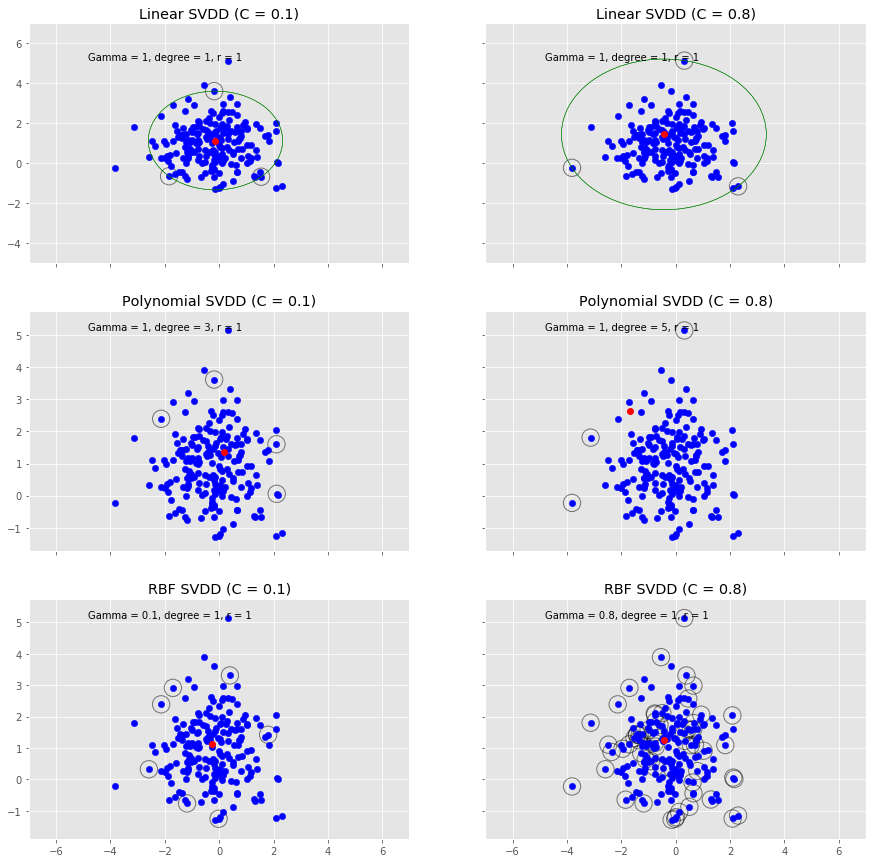

In [1086]:
n_samples=200
X,Y = make_blobs(n_samples =n_samples , centers=1, center_box=(-1.0, 1.0), 
                 cluster_std=1.1, random_state=42)

mode_list = [['polynomial', 1, 1, 1, 0.1,'Linear SVDD (C = 0.1)', '$X_1$','$X_2$'], 
             ['polynomial',1, 1, 1, 0.8,'Linear SVDD (C = 0.8)', '$X_1$','$X_2$'],
             ['polynomial', 1, 3, 1, 0.1,'Polynomial SVDD (C = 0.1)', '$X_1$','$X_2$'],
             ['polynomial', 1, 5, 1, 0.8,'Polynomial SVDD (C = 0.8)', '$X_1$','$X_2$'],
             ['rbf',0.1, 1, 1, 0.1, 'RBF SVDD (C = 0.1)', '$X_1$','$X_2$'],          
             ['rbf', 0.8, 1, 1, 0.8, 'RBF SVDD (C = 0.8)', '$X_1$','$X_2$']]

f, ax = plt.subplots(3,2, sharex='col', sharey='row', figsize=(15, 15))
        
for idx, info in zip(product([0, 1,2], [0 ,1]), mode_list):
    
    mode, gamma, degree, r, C, title, x_axis, y_axis  = info
    svdd = SVDD(X, Y, mode, gamma, degree, r, C)
    alpha = svdd.alpha 
    center = svdd.center      
    support_vec_idx = svdd.support_vec_idx 
    radius = svdd.radius
    
    ax[idx[0], idx[1]].scatter(X[support_vec_idx,0], X[support_vec_idx,1], alpha=0.5, 
                        s=300, linewidth=1, facecolors='none', edgecolors='black')
    ax[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c='blue', s=40)
    ax[idx[0], idx[1]].plot(center[0][0], center[0][1],'ro')
    ax[idx[0], idx[1]].set_title(title)
    ax[idx[0], idx[1]].set_title(title)
    ax[idx[0], idx[1]].text(min(X[:, 0]-1), max(X[:, 1]),'Gamma = {}, degree = {}, r = {}'.format(gamma, degree, r))
    
    if title == 'Linear SVDD (C = 0.1)' or title == 'Linear SVDD (C = 0.8)':
        
        ax[idx[0], idx[1]].set_xlim([-7, 7])
        ax[idx[0], idx[1]].set_ylim([-5, 7])
        circ_1 = plt.Circle((center[0][0], center[0][1]), radius= radius[0], color='g', fill = False)
        circ_2 = plt.Circle((center[0][0], center[0][1]), radius= radius[-1], color='g', fill = False)
        ax[idx[0], idx[1]].add_patch(circ_1)
        ax[idx[0], idx[1]].add_patch(circ_2)
        

plt.savefig('SVDD_benchmark.png')  
plt.show()

In [ ]:
## TEST ON Linear KERNEL

from sklearn.metrics import confusion_matrix, classification_report
df = df[df['era'] == 'era3']
X = df.values[:,3:-1]
Y = df.values[:,-1]
Y = Y.astype('int')

gamma = 1
degree = 1
r = 1

svdd = SVDD(X, Y, mode, gamma, degree, r, C)
alpha = svdd.alpha 
center = svdd.center      
support_vec_idx = svdd.support_vec_idx 
radius = svdd.radius

k_kmeans = Kernel_KMEANS(X, Y, mode='rbf', gamma=i, degree=1, r=1, n_clusters=2)
cluster_dict = k_kmeans.cluster_dict
Y_ = np.ones((X.shape[0],))
temp_list = [cluster_dict[0][i][0] for i in range(len(cluster_dict[0]))]
Y_[temp_list] = 0

print("For gamma value = {}".format(i))
print(classification_report(Y, Y_))
print('\n')

In [ ]:
## TEST ON RBF KERNEL

from sklearn.metrics import confusion_matrix, classification_report
df = df[df['era'] == 'era3']
X = df.values[:,3:-1]
Y = df.values[:,-1]
Y = Y.astype('int')

gamma =list(np.random.choice(np.linspace(0,1, 100),10))
for i in gamma:
    k_kmeans = Kernel_KMEANS(X, Y, mode='rbf', gamma=i, degree=1, r=1, n_clusters=2)
    cluster_dict = k_kmeans.cluster_dict
    Y_ = np.ones((X.shape[0],))
    temp_list = [cluster_dict[0][i][0] for i in range(len(cluster_dict[0]))]
    Y_[temp_list] = 0
    
    print("For gamma value = {}".format(i))
    print(classification_report(Y, Y_))
    print('\n')

In [ ]:
## TEST ON RBF KERNEL

from sklearn.metrics import confusion_matrix, classification_report
df = df[df['era'] == 'era3']
X = df.values[:,3:-1]
Y = df.values[:,-1]
Y = Y.astype('int')

gamma =list(np.random.choice(np.linspace(0,1, 100),10))
for i in gamma:
    k_kmeans = Kernel_KMEANS(X, Y, mode='rbf', gamma=i, degree=1, r=1, n_clusters=2)
    cluster_dict = k_kmeans.cluster_dict
    Y_ = np.ones((X.shape[0],))
    temp_list = [cluster_dict[0][i][0] for i in range(len(cluster_dict[0]))]
    Y_[temp_list] = 0
    
    print("For gamma value = {}".format(i))
    print(classification_report(Y, Y_))
    print('\n')

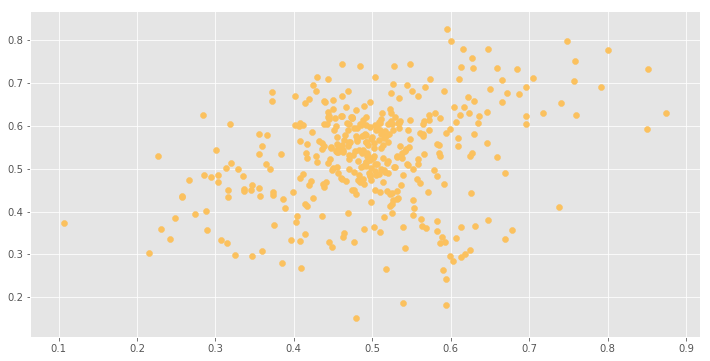

In [1091]:
df = df[df['era'] == 'era3']
X = df.values[:,3:-1]
Y = df.values[:,-1]

plt.scatter(X[:,0],X[:,1])
plt.show()

# Archive

## Kernalised K means

In [1012]:
## Helper functions
GAMMA = 1
DEGREE = 1
R = 1
MODE = 'polynomial'
## Helper Functions

# Kernel functions
def kernels(x_i, x_j, mode = MODE):

    if mode == "rbf":
        return np.exp(-GAMMA * np.linalg.norm(x_i - x_j)**2)

    elif mode == "polynomial":
        return (GAMMA*np.dot(x_i,x_j) + R) ** DEGREE

    elif mode == "sigmoid":
        return np.tanh(GAMMA*np.dot(x_i,x_j) + R)
    
    
## Blobs Dataset 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
n_samples=200
X,Y = make_blobs(n_samples =n_samples , centers=1, center_box=(-1.0, 1.0), 
                 cluster_std=1.1, random_state=42)
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()


## Calculate kernel matrix 

kernel = np.zeros((n_samples,n_samples))
for i in range(X.shape[0]):
    for j in range(X.shape[0]):
        kernel[i,j] = kernels(X[i], X[j])

        
## Putting together the variables 
C = 0.8

alpha = cp.Variable((n_samples,1))

constraint_1 = [alpha[i] >= 0  for i in range(n_samples)]
constraint_2 = [alpha[i] <= C   for i in range(n_samples)]
constraint_3 = [np.ones((1,X.shape[0]))*alpha == 1 ]
constraints = constraint_1 + constraint_2 + constraint_3

objective_1 = alpha.T*kernel.diagonal()
objective_2 = cp.quad_form(alpha, cp.Parameter(shape=kernel.shape, value=kernel, PSD=True))
objective = cp.Minimize(-(objective_1 - objective_2))



prob = cp.Problem(objective, constraints)
prob.solve()



temp_list = list()
for i in range(alpha.shape[0]):
    if alpha.value[i] > (0+0.0001) and alpha.value[i] < (C-0.0001):
        temp_list.append(i)
        
        
radius_list = list()
third_term = np.matmul(alpha.value.T,np.matmul(kernel, alpha.value))


for k in temp_list:
    temp_second_term = 0
    for i in range(n_samples):
        temp_second_term += alpha.value[i]*kernel[i,k]

    temp_radius = np.sqrt(kernel[k,k] - 2*temp_second_term + third_term)
    radius_list.append(temp_radius)
    radius_list.sort()
    
    
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([6,-6])
ax.set_ylim([6,-6])
#ax.set_xlim([max(radius_list[0],-np.max(X)), min(-radius_list[0],np.min(X))])
#ax.set_ylim([max(radius_list[0],-np.max(X)), min(-radius_list[0],np.min(X))])
plt.scatter(X[temp_list,0], X[temp_list,1], alpha=0.5, 
                        s=300, linewidth=1, facecolors='none', edgecolors='black')
circ_1 = plt.Circle((center[0][0], center[0][1]), radius= radius_list[0], color='g', fill = False)
circ_2 = plt.Circle((center[0][0], center[0][1]), radius= radius_list[-1], color='g', fill = False)
plt.scatter(X[:,0], X[:,1], alpha=0.5, c = 'blue')
plt.plot(center[0][0], center[0][1],'ro') 
ax.add_patch(circ_1)
ax.add_patch(circ_2)
plt.show()

## Kernalized SVDD

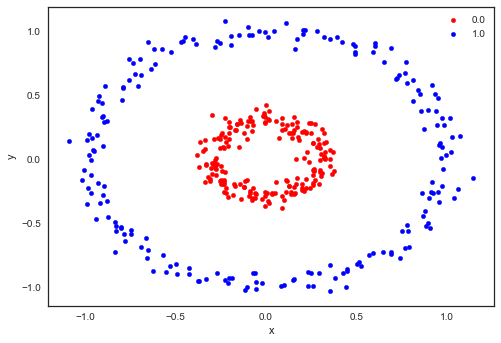

In [1977]:

GAMMA = 4
DEGREE = 4
R = 5
MODE = 'rbf'
## Helper Functions

# Kernel functions
def kernels(x_i, x_j, mode = MODE):

    if mode == "rbf":
        return np.exp(-GAMMA * np.linalg.norm(x_i - x_j)**2)

    elif mode == "polynomial":
        return (GAMMA*np.dot(x_i,x_j) + R) ** DEGREE

    elif mode == "sigmoid":
        return np.tanh(GAMMA*np.dot(x_i,x_j) + R)
    
# Function to calculate the third term in the dist equation
def _third_term(idx_list, kernel):

    temp = 0
    for j in idx_list:
        for l in idx_list:
            temp += kernel[j,l]
    
    if idx_list: return temp/(len(idx_list)**2)
    else: return temp


# Function to calculate the second term in the dist equation
def _second_term(idx_list, kernel, i):
    
    temp = 0
    for j in idx_list:
        temp += kernel[i,j]
   
    if idx_list: return 2*temp/len(idx_list)
    else: return temp
    

# Function to reassign instances to respective clusters based on distance
def _reassign(dist_dict, n_samples, n_clusters, X):
    
    global cluster_dict, stability
    
    temp_cluster_dict = dict()
    for c in range(n_clusters): temp_cluster_dict[c] = list()
    for i in range(n_samples):
        
        temp_list = [dist_dict[c][i] for c in range(n_clusters)]
        temp_cluster_dict[temp_list.index(min(temp_list))].append((i,X[i]))
    
    check(temp_cluster_dict)
    
    return temp_cluster_dict
        
    
# checking if stability has been attained
def check(temp_cluster_dict):
  
    global cluster_dict, stability
    temp_1 = [cluster_dict[0][i][0] for i in range(len(cluster_dict[0]))]
    temp_2 = [temp_cluster_dict[0][i][0] for i in range(len(temp_cluster_dict[0]))]
    
    if temp_1 == temp_2:stability = True
        
    

## Select dataset
n_samples=400
#X, Y = make_moons(n_samples=n_samples, random_state=1)
#df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
X, Y = make_circles(n_samples, factor= 0.3, noise= 0.05, random_state=42)
#X,Y = make_blobs(400, 2,centers = 2,random_state=2)
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))

## Select k centroids at random
n_clusters = 2
#random.seed(1)
idx = random.sample(range(1, X.shape[0]), n_clusters)
centers_temp = X[idx]

## Create k clusters by assigning points randomly to the selected clusters
# dict where key is cluster number and the value is a list of tuples containting 
# idx and instance coordinates (323, array([3.233, 0.44334]))
cluster_dict = dict() 
shuffled_idx = list(np.random.permutation(n_samples))
for c in range(n_clusters): cluster_dict[c] = list()
for i in range(n_samples): 
    random_centroid = random.randint(0,n_clusters-1)
    cluster_dict[random_centroid].append((shuffled_idx[i],X[shuffled_idx[i]]))

## Caculating the kernel matrix
kernel = np.ones((n_samples, n_samples))
for i in range(X.shape[0]):
    for j in range(X.shape[0]):
        kernel[i,j] = kernels(X[i],X[j])
        

chk = 0
stability = False
while not stability:
    
    #print(chk)
    chk += 1

    ## Caculating similarity/distance between points and clusters in new space
    
    dist_dict = dict() # dict containing distance of points and clusters

    for c in range(n_clusters):
        
        dist_dict[c] = list()
        # Calculating the 3rd term in the distance equation
        temp_idx_list = [cluster_dict[c][i][0] for i in range(len(cluster_dict[c]))]
        third_term = _third_term(temp_idx_list, kernel)
        for i in range(n_samples):
             # Calculating the 2nd term in the distance equation
            second_term = _second_term(temp_idx_list, kernel, i)
        
            # Calculating the distance and appending to a list
            dist_i = kernel[i,i] - 2*second_term + third_term
            dist_dict[c].append(dist_i)
            
    cluster_dict = _reassign(dist_dict, n_samples, n_clusters, X)   
    if chk == 20 : break
            

## Plotting
Y_ = np.ones((n_samples,))
temp_list = [cluster_dict[0][i][0] for i in range(len(cluster_dict[0]))]
Y_[temp_list] = 0
df_temp = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y_))
colors = {0:'red', 1:'blue', 2:'green', 3:'pink'}
fig, ax = plt.subplots()
grouped = df_temp.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

plt.show()

In [134]:
import torch
import torch.nn as nn
def init_weights(m):
        print(m)
        if type(m) == nn.Linear:
            m.weight.data.normal_(0.00, 0.02)
            print(m.weight)
#if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))

net.apply(init_weights)

Linear(in_features=2, out_features=2, bias=True)
Parameter containing:
tensor([[ 0.0171, -0.0130],
        [-0.0210, -0.0024]], requires_grad=True)
Linear(in_features=2, out_features=2, bias=True)
Parameter containing:
tensor([[ 0.0029, -0.0071],
        [ 0.0192,  0.0371]], requires_grad=True)
Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
)


Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
)